C:\Users\quent\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 18277396.0000 - mae: 4201.1387
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16333616.0000 - mae: 3976.9875
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8112127.5000 - mae: 2721.5967
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 542743.0000 - mae: 582.9779
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 295480.3750 - mae: 439.5444
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 285081.0938 - mae: 425.4300
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 252054.5938 - mae: 412.4481
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 244007.7969 - mae: 406.4067
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 198801.6250 - mae: 361.5327
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 201971.3750 - mae: 371.7345
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 176839.3125 - mae: 343.2324
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2

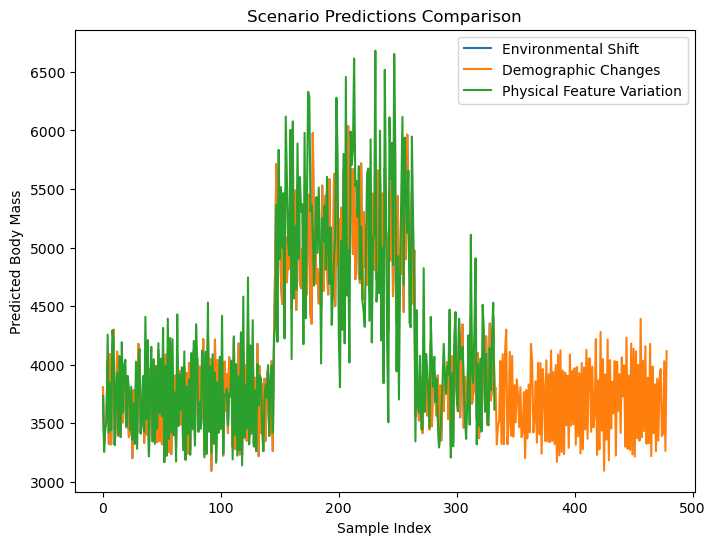

Baseline Predictions (Physical Feature Variation):
[[3731.628 ]
 [3255.1763]
 [3464.2012]
 [3521.029 ]
 [4256.252 ]
 [3421.0166]
 [3842.4243]
 [3438.1978]
 [4292.801 ]
 [4203.749 ]]
Predictions after Sensitivity Adjustment (Bill Length +2 mm):
[[3659.9126]
 [3271.6016]
 [3505.679 ]
 [3518.8167]
 [4222.715 ]
 [3461.9663]
 [3769.2832]
 [3480.4937]
 [4262.2607]
 [4134.0566]]


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, silhouette_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Load the cleaned dataset
file_path = "C:/Users/quent/Downloads/penguins (1).csv"
penguins_data = pd.read_csv(file_path).dropna()

# Encode categorical columns
label_encoder_species = LabelEncoder()
label_encoder_sex = LabelEncoder()
penguins_data['species_encoded'] = label_encoder_species.fit_transform(penguins_data['species'])
penguins_data['sex_encoded'] = label_encoder_sex.fit_transform(penguins_data['sex'])

# Features and target variables
X = penguins_data[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'sex_encoded']]
y_regression = penguins_data['body_mass_g']
y_classification = penguins_data['species_encoded']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------- Regression Model -------------------------
# Split the data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_scaled, y_regression, test_size=0.2, random_state=42)

# Define the regression model
reg_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_reg.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Single output for regression
])

# Compile the model
reg_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

# Train the model
reg_model.fit(X_train_reg, y_train_reg, epochs=50, batch_size=8, verbose=1)

# Evaluate the model
reg_test_loss, reg_test_mae = reg_model.evaluate(X_test_reg, y_test_reg, verbose=0)
print(f"Regression Model Test MAE: {reg_test_mae:.2f}")

# ------------------------- Scenario Development -------------------------
# 1. Environmental Shift: Decrease body mass by 10%
scenario_environmental_shift = penguins_data.copy()
scenario_environmental_shift['body_mass_g'] *= 0.9

# 2. Demographic Changes: Oversample Adelie species
scenario_demographic_changes = penguins_data.copy()
adelie_species = scenario_demographic_changes[scenario_demographic_changes['species'] == 'Adelie']
scenario_demographic_changes = pd.concat([scenario_demographic_changes, adelie_species])

# 3. Physical Feature Variation: Perturb bill length and flipper length
scenario_physical_variation = penguins_data.copy()
scenario_physical_variation['bill_length_mm'] *= np.random.uniform(0.9, 1.1, size=len(scenario_physical_variation))
scenario_physical_variation['flipper_length_mm'] *= np.random.uniform(0.9, 1.1, size=len(scenario_physical_variation))

# ------------------------- Scenario Simulations -------------------------
# Simulate predictions for each scenario
scenarios = {
    "Environmental Shift": scenario_environmental_shift,
    "Demographic Changes": scenario_demographic_changes,
    "Physical Feature Variation": scenario_physical_variation
}

scenario_results = {}
for scenario_name, scenario_data in scenarios.items():
    X_scenario = scaler.transform(scenario_data[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'sex_encoded']])
    predictions = reg_model.predict(X_scenario)
    scenario_results[scenario_name] = predictions

# ------------------------- Sensitivity Analysis -------------------------
# Select features for sensitivity analysis in "Physical Feature Variation"
sensitivity_data = scenario_physical_variation.copy()
sensitivity_data['bill_length_mm'] += 2  # Increase bill length by 2 mm
X_sensitivity = scaler.transform(sensitivity_data[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'sex_encoded']])
sensitivity_predictions = reg_model.predict(X_sensitivity)

# ------------------------- Analysis and Visualization -------------------------
# Example Visualization for Scenario Results
plt.figure(figsize=(8, 6))
plt.plot(scenario_results["Environmental Shift"], label="Environmental Shift")
plt.plot(scenario_results["Demographic Changes"], label="Demographic Changes")
plt.plot(scenario_results["Physical Feature Variation"], label="Physical Feature Variation")
plt.xlabel("Sample Index")
plt.ylabel("Predicted Body Mass")
plt.title("Scenario Predictions Comparison")
plt.legend()
plt.show()

# Print sensitivity analysis results
print("Baseline Predictions (Physical Feature Variation):")
print(scenario_results["Physical Feature Variation"][:10])  # Example subset
print("Predictions after Sensitivity Adjustment (Bill Length +2 mm):")
print(sensitivity_predictions[:10])


Insights and Implications

Environmental Shift: Predicted decreases in body mass highlight the impact of climate change on penguin populations, underscoring the need for conservation efforts.

Demographic Changes: Imbalances in species populations can skew model predictions, demonstrating the importance of balanced datasets in ecological studies.

Physical Feature Variation: The model's sensitivity to key features like bill length and flipper length suggests that monitoring these traits in real-world populations could provide early indicators of environmental or ecological shifts.